In [1]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import asdf
from tqdm.dask import TqdmCallback

import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()

from astropy.modeling import models as m
from astropy.nddata import StdDevUncertainty
from sunraster.instr.spice import read_spice_l2_fits
from sospice.calibrate import spice_error

from astropy.modeling.fitting import parallel_fit_dask
from astropy.modeling import fitting

In [2]:
%matplotlib inline

We set up the cube in the same way, just making sure to keep all of the extra attributres on the NDCube instance.

In [3]:
data_dir = Path('./data')
file = data_dir / 'solo_l2_spice_n_ras_20220403t121537_v07_100664022_000.fits'
window = 'Ly-gamma-CIII group (Merged)'

In [4]:
spice = read_spice_l2_fits(str(file))[window]
spice

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 59672.510847 from DATE-OBS.
Set MJD-BEG to 59672.510847 from DATE-BEG.
Set MJD-AVG to 59672.515708 from DATE-AVG.
Set MJD-END to 59672.520566 from DATE-END'. [astropy.wcs.wcs]


SpectrogramCube
---------------
Time Period: ['2022-04-03 12:15:39.675' '2022-04-03 12:29:34.425']
Instrument axes: ['raster scan' 'spectral' 'slit' 'slit step']
Pixel dimensions: [  1  64 830 160] pix
Longitude range: [-2033.40023367 -1348.47373386] arcsec
Latitude range: [  74.80286184 1018.52672069] arcsec
Spectral range: [9.72991075e-08 9.79053565e-08] m
Data unit: W / (nm sr m2)

In [5]:
av_cojstant_noise_level, sigmadict = spice_error(data=spice.data, header=spice.meta)
sigma = sigmadict["Total"].value
spice.mask = spice.mask | np.isnan(sigma) | (sigma <= 0)
spice.uncertainty = StdDevUncertainty(sigma)

W / (nm sr m2)
Getting observation parameters from Ly-gamma-CIII group (Merged)

Slit: 4.0 arcsec
Bin: (1, 1)
Exposure time: 5.0 s
Window width: 64.0 pix
Average wavelength: 97.602232 nm
RADCAL: 30.9672782204 m2 ct nm sr / W
            


In [22]:
spice

SpectrogramCube
---------------
Time Period: ['2022-04-03 12:15:39.675' '2022-04-03 12:29:34.425']
Instrument axes: ['raster scan' 'spectral' 'slit' 'slit step']
Pixel dimensions: [  1  64 830 160] pix
Longitude range: [-2033.40023367 -1348.47373386] arcsec
Latitude range: [  74.80286184 1018.52672069] arcsec
Spectral range: [9.72991075e-08 9.79053565e-08] m
Data unit: W / (nm sr m2)

We crop out the same 160x160 region of the raster to fit.

In [27]:
n = 160
i = 400
j = 0

spice_small = spice[0, :, i:i+n, j:j+n]
spice_small

SpectrogramCube
---------------
Time Period: ['2022-04-03 12:15:39.675' '2022-04-03 12:29:34.425']
Instrument axes: ['spectral' 'slit' 'slit step']
Pixel dimensions: [ 64 160 160] pix
Longitude range: [-2017.15316827 -1372.53955926] arcsec
Latitude range: [513.3415694  722.51317552] arcsec
Spectral range: [9.72991075e-08 9.79053565e-08] m
Data unit: W / (nm sr m2)

We set up the initial model with units.

In [28]:
initial_model = m.Const1D(amplitude=1*spice.unit) + m.Gaussian1D(mean=976.8*u.AA, amplitude=4*spice.unit, stddev=1*u.AA)

Calculate the average spectra over our region of interest

In [29]:
avg_spectra = spice_small.rebin((1, *spice_small.data.shape[1:]))
avg_spectra = avg_spectra[:, 0, 0]  # drop length one dimensions
avg_spectra

SpectrogramCube
---------------
Time Period: None
Instrument axes: None
Pixel dimensions: [64] pix
Longitude range: None
Latitude range: None
Spectral range: [9.72991075e-08 9.79053565e-08] m
Data unit: W / (nm sr m2)

Now we plot the initial guess and the average spectra.

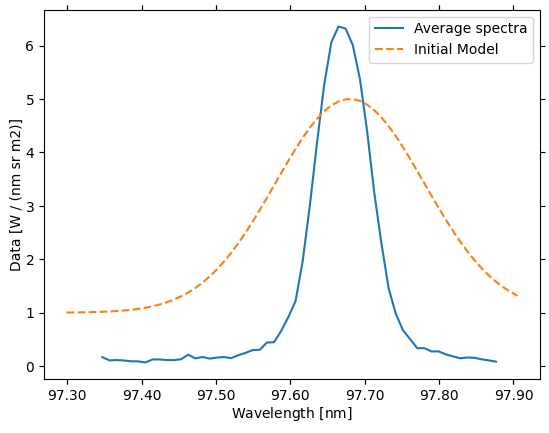

In [30]:
fig = plt.figure()
ax = avg_spectra.plot(axes_units=[u.nm], label="Average spectra")
ax.coords["wavelength"].set_major_formatter("x.xx")
wave = avg_spectra.axis_world_coords("em.wl")[0]
ax.plot(avg_spectra.wcs.world_to_pixel(wave), initial_model(wave), linestyle="--", label="Initial Model")
plt.legend()

Weights are calculated the same way as in pyCFIT, but are set to 0 where the pixels are masked, so no fitting is done there.

In [31]:
weights = 1 / spice_small.uncertainty.array
weights[spice_small.mask] = 0

Calculate our wavelength axis and convert to Angstroms (from meters).

In [32]:
wave = spice.axis_world_coords("em.wl")[0].to(u.AA)

We now use the new parallel fitting function in astropy. We also use tqdm to draw a progress bar. Using the default setting this function will use process based parallelism up to the number of cores available on the machine running the code.

In [40]:
%%time

with TqdmCallback(desc="raster fit"):
    spice_model_fit = parallel_fit_dask(
        model=initial_model,
        fitter=fitting.TRFLSQFitter(),
        fitting_axes=0,
        data=spice_small.data,
        data_unit=spice_small.unit,
        world=(wave,),
        weights=weights,
        fitter_kwargs={"filter_non_finite": True}, # Filter out non-finite values
    ) 

/home/stuart/.virtualenvs/spice-fitting/lib/python3.12/site-packages/dask/base.py:1487: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


raster fit:   0%|          | 0/320 [00:00<?, ?it/s]

CPU times: user 642 ms, sys: 164 ms, total: 806 ms
Wall time: 31 s


We now extract the pixel values for our wavelengths and also evalulate the fit for every pixel.

In [71]:
pixel = avg_spectra.wcs.world_to_pixel(wave)
all_fits = spice_model_fit(wave[:, None, None])

Now let's plot every fit, just to compare.

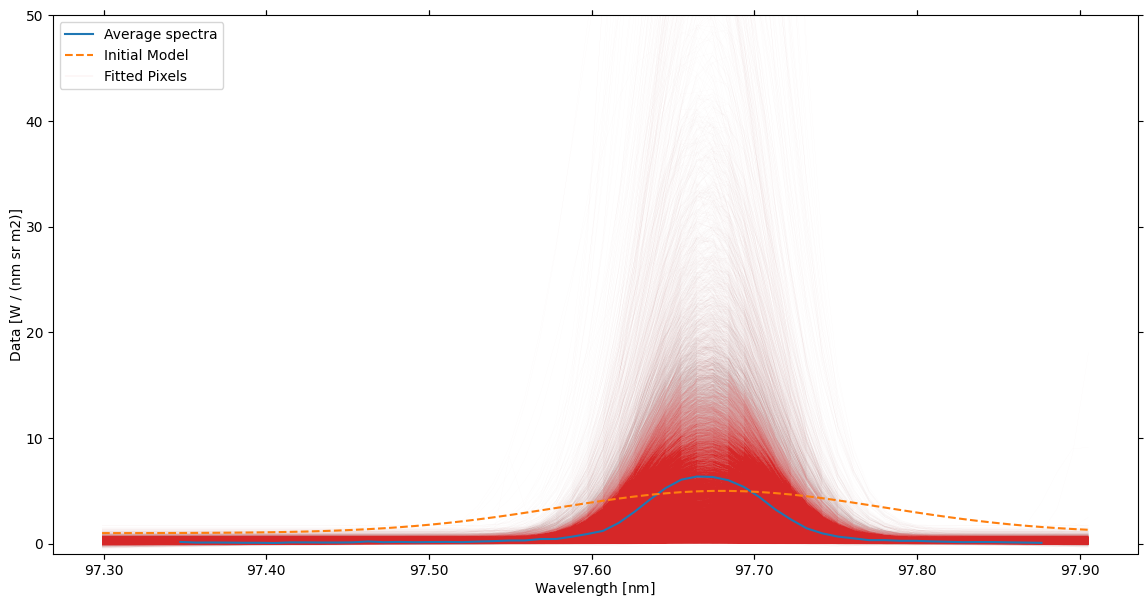

In [110]:
fig = plt.figure(figsize=(14, 7))
ax = avg_spectra.plot(axes_units=[u.nm], label="Average spectra", zorder=99999)
ax.coords["wavelength"].set_major_formatter("x.xx")
wave = avg_spectra.axis_world_coords("em.wl")[0]
ax.plot(pixel, initial_model(wave), linestyle="--", label="Initial Model", zorder=99999)
for fit_arr in all_fits.reshape((64, 160*160)).T:
    line, = ax.plot(pixel, fit_arr, alpha=0.1, color="C3", linewidth=0.05)
line.set_label("Fitted Pixels")
leg = plt.legend(loc="upper left")
for lh in leg.legend_handles:
    lh.set_alpha(1)
_ = ax.set_ylim((-1, 50))

Finally, let's create the same diagnostic plot of amplitude shift from the initial model.

In [41]:
shift_from_initial = spice_model_fit.amplitude_1 - initial_model.amplitude_1

In [42]:
spice_small_mean = spice_small.rebin((64, 1, 1))[0]

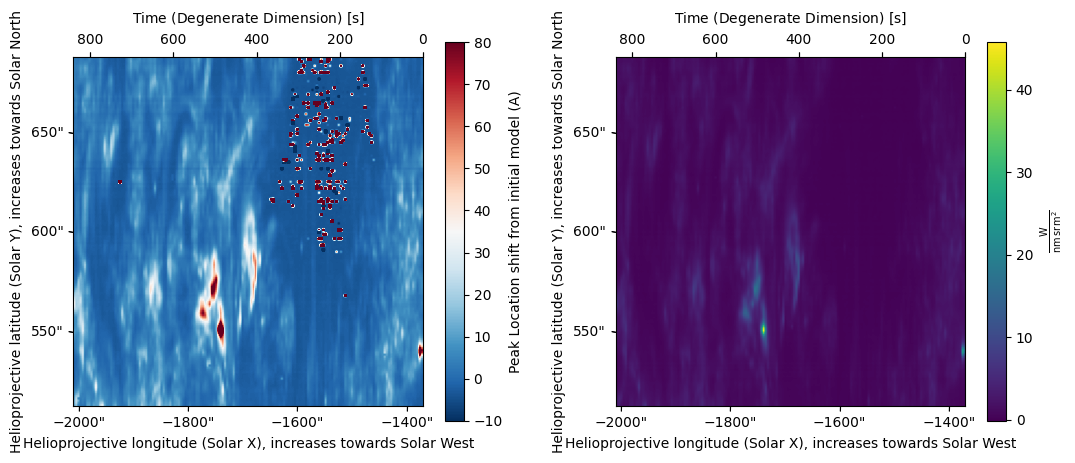

In [111]:
fig = plt.figure(figsize=(11, 5))
ax = plt.subplot(121, projection=spice_small[0].wcs)
im = ax.imshow(shift_from_initial.value, cmap="RdBu_r", origin="lower", vmin=-10, vmax=80)
plt.colorbar(im, label=f"Peak Location shift from initial model (A)")
ax = plt.subplot(122, projection=spice_small_mean.wcs)
spice_small_mean.plot(axes=ax)
plt.colorbar(ax=ax, label=f"{spice.unit:latex}")
fig.tight_layout()